## Inverse KL-divergence between the distribution of the particles and the target during sampling (Appendix C)

/data/shirin/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


U6 M=6317
U5 M=558
U1 M=154
U11 M=19


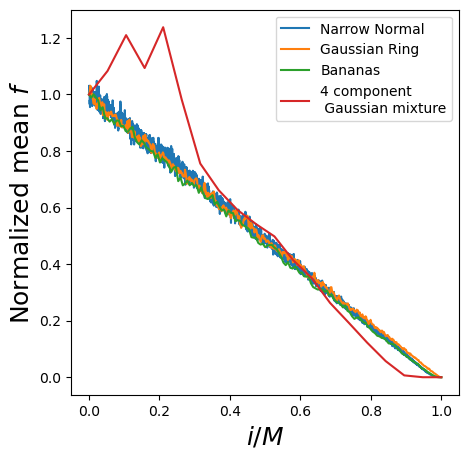

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, pickle

from utils.experiments import Default_ARGS as args
from utils.targets import synthetic_targets
from utils.experiments import get_modified_experiment, get_dirs
from utils.plots import plot_energy_heatmap, plot_particles
from sampling.utils import get_sampler, estimate

args.testname = "tests/ffa772"

## Target distribution
args.target='U6'
args.latent_dim=2
args.dataset=None
args.context_dim=0

## Sampling parameters
args.seed = 1
#args.M=128
args.M=8
args.n_samples=1024
args.schedule='linear'
args.path='power'
args.annealing_alpha=0.
args.device=1
args.redo=True

## Transitions
args.transition='HMC'
args.transition_hidden_dim=4
args.transition_step_size=0.5
args.transition_update = 'fixed'
args.transition_n_tune=1
args.hmc_partial_refresh = 10
args.hmc_alpha = 1.
args.hmc_n_leapfrogs = 1

args.min_step=0.0001
args.max_step=1./128
args.ratio=0.7
args.conditional=True
dd = 32
args.dt = 1./dd
args.max_M = 65536
args.kde = False
args.tol=1e-3

if args.target in ['U2', 'U3', 'U4']:
    LIMS = np.array([[-32, 32], [-4, 4]])
else:
    LIMS = np.array([[-4, 4], [-4, 4]])


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
    
linestyles = {'CR': '-', 'Adaptive':'--'}
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(5, 5))
did_ada=''

args.annealing_alpa = 0.
for sampler in ['CR']:
    args.sampler = sampler
    args, experiment, label = get_modified_experiment(args, args.sampler, config={
        'transition_step_size':args.transition_step_size,
        'transition_update':args.transition_update,
        'transition_n_tune':args.transition_n_tune,
        'hmc_partial_refresh': args.hmc_partial_refresh,
        'hmc_alpha': args.hmc_alpha,
        'hmc_n_leapfrogs': args.hmc_n_leapfrogs,
    })
    plot_x = None
    labels = ['Narrow Normal', 'Gaussian Ring', 'Bananas', '4 component\n Gaussian mixture']
    if sampler == 'Adaptive':
        labels = ['_']*4
    if sampler == 'Adaptive':
        did_ada = f'A{args.ratio}{"c" if args.conditional else ""}'
    i = 0
    for label, target in zip(labels, ['U6', 'U5', 'U1', 'U11']):

        args.target = target
        target_log_density = synthetic_targets[args.target]
        sampler, dirs = get_sampler(args, experiment, target_log_density, make_dirs=False)
        sampler.eval()

        z, log_w, transition_logs = sampler.sample(args.n_samples, plot_x, update_step_size=True, log=False)

        sampler.tune_beta = False
        z, log_w, transition_logs = sampler.sample(2*args.n_samples, plot_x, update_step_size=False, log=True)
        zs = transition_logs['z'].reshape(args.n_samples, target_log_density.data_dim, -1)
        log_ws = transition_logs['log_w'].reshape(args.n_samples, -1)
        betas = torch.cat([torch.tensor([0.]).to(sampler.beta.device), sampler.beta], dim=0)

        print(f'{target} M={sampler.M}')

        f0 = transition_logs['f'].cpu().numpy()[0]
        ax.plot(np.arange(transition_logs['f'].shape[0])/sampler.M, 
                   transition_logs['f'].cpu().numpy()/f0, label=label,
                   linestyle=linestyles[args.sampler], c=colors[i])
        ax.set_ylabel(r'Normalized mean $f$', fontsize=18)
        ax.set_xlabel(r'$i/M$', fontsize=18)   
        ax.legend()
        i += 1

os.makedirs(f'{args.testname}/plots', exist_ok=True)
plt.savefig(f'{args.testname}/plots/f{dd}{did_ada}.pdf', format='pdf', transparent=True, bbox_inches='tight', pad_inches = 0)

## Annealing schedule for different $\alpha$s and target distributions

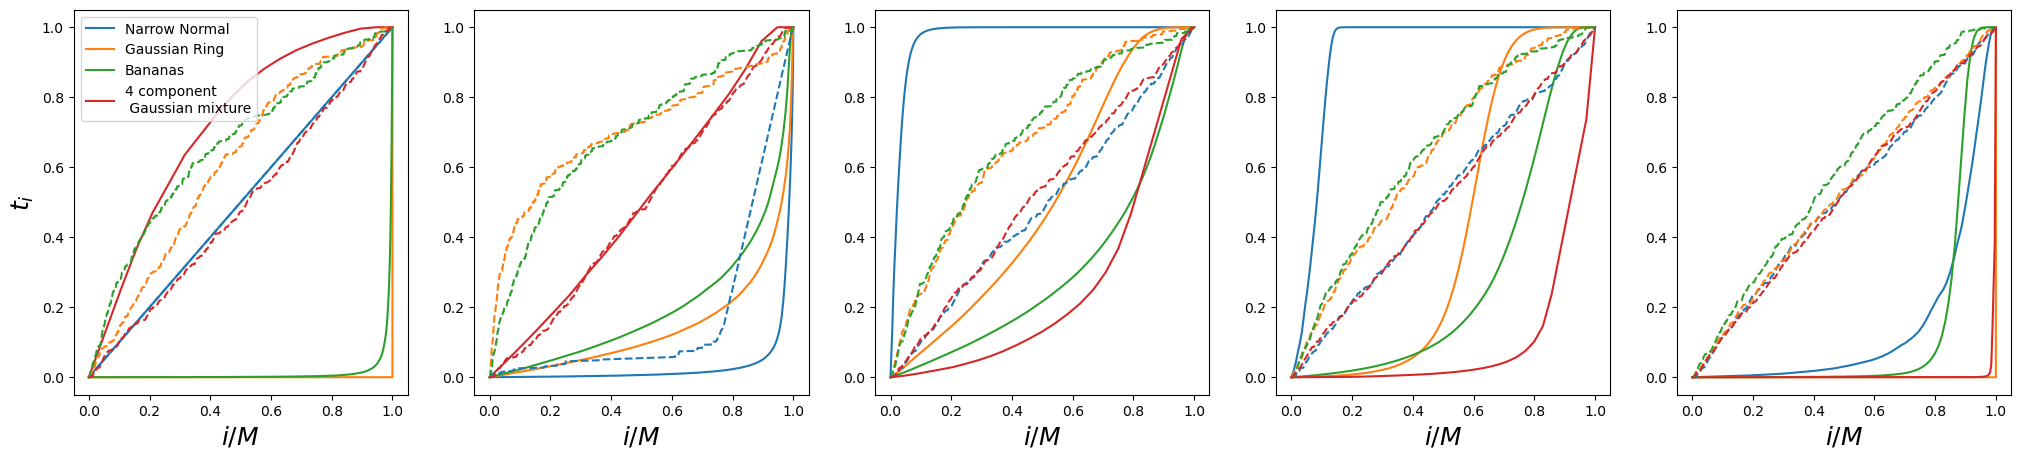

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, pickle

from utils.experiments import Default_ARGS as args
from utils.targets import synthetic_targets
from utils.experiments import get_modified_experiment, get_dirs
from utils.plots import plot_energy_heatmap, plot_particles
from sampling.utils import get_sampler, estimate

args.testname = "tests/ffa772"

## Target distribution
args.target='U6'
args.latent_dim=2
args.dataset=None
args.context_dim=0

## Sampling parameters
args.seed = 1
args.M=8
args.n_samples=1024
args.schedule='linear'
args.path='power'
args.annealing_alpha=0.
args.device=1
args.redo=True

## Transitions
args.transition='HMC'
args.transition_hidden_dim=4
args.transition_step_size=0.5
args.transition_update = 'fixed'
args.transition_n_tune=1
args.hmc_partial_refresh = 10
args.hmc_alpha = 1.
args.hmc_n_leapfrogs = 1

args.min_step=0.0001
args.max_step=1./128
args.ratio=0.7
args.conditional=True
dd = 32
args.dt = 1./dd
args.max_M = 8192
args.kde = False
args.tol=1e-3

if args.target in ['U2', 'U3', 'U4']:
    LIMS = np.array([[-32, 32], [-4, 4]])
else:
    LIMS = np.array([[-4, 4], [-4, 4]])


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
    
linestyles = {'CR': '-', 'Adaptive':'--'}
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(25, 5))
did_ada=''
for a, alpha in enumerate([-0.5, 0., 0.5, 1., 2.]):
    for sampler in ['CR', 'Adaptive']:
        args.sampler = sampler
        args.annealing_alpha = alpha
        args, experiment, label = get_modified_experiment(args, args.sampler, config={
            'transition_step_size':args.transition_step_size,
            'transition_update':args.transition_update,
            'transition_n_tune':args.transition_n_tune,
            'hmc_partial_refresh': args.hmc_partial_refresh,
            'hmc_alpha': args.hmc_alpha,
            'hmc_n_leapfrogs': args.hmc_n_leapfrogs,
        })
        plot_x = None
        labels = ['Narrow Normal', 'Gaussian Ring', 'Bananas', '4 component\n Gaussian mixture']
        if sampler == 'Adaptive':
            labels = ['_']*4
        if sampler == 'Adaptive':
            did_ada = f'A{args.ratio}{"c" if args.conditional else ""}'
        i = 0
        for label, target in zip(labels, ['U6', 'U5', 'U1', 'U11']):

            args.target = target
            target_log_density = synthetic_targets[args.target]
            sampler, dirs = get_sampler(args, experiment, target_log_density, make_dirs=True)
            sampler.eval()

            z, log_w, transition_logs = sampler.sample(args.n_samples, plot_x, update_step_size=True, log=False)

            sampler.tune_beta = False
            z, log_w, transition_logs = sampler.sample(2*args.n_samples, plot_x, update_step_size=False, log=True)
            zs = transition_logs['z'].reshape(args.n_samples, target_log_density.data_dim, -1)
            log_ws = transition_logs['log_w'].reshape(args.n_samples, -1)
            betas = torch.cat([torch.tensor([0.]).to(sampler.beta.device), sampler.beta], dim=0)

            ax[a].plot(np.arange(betas.shape[0])/sampler.M, betas.cpu().numpy(), 
                       label=label, linestyle=linestyles[args.sampler],
                       c=colors[i])
            ax[a].set_xlabel(r'$i/M$', fontsize=18)
            
            i += 1

ax[0].legend()
ax[0].set_ylabel(r'$t_i$', fontsize=18)

os.makedirs(f'plots', exist_ok=True)
plt.savefig(f'{args.testname}/plots/schedules{dd}.pdf', format='pdf', transparent=True, bbox_inches='tight', pad_inches = 0)


## Sampling from 2d distributions

/data/shirin/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tests/ffa772/None/U2/32/CR/HMC.0.5.10.1.01f_p0.0.0.03125.0.001.8192
log Z: None, log E w: 2.349
Z    : None, E w    : 10.478
ESS  : (3814.3 +- 715.8)/4096
tensor([2.9368, 0.9226, 3.3237, 0.6022, 2.9172], device='cuda:0')
ESS =  107.2371597290039

M =  90
tests/ffa772/None/U3/32/CR/HMC.0.5.10.1.01f_p0.0.0.03125.0.001.8192
log Z: None, log E w: 3.392
Z    : None, E w    : 29.717
ESS  : (3651.4 +- 956.0)/4096
tensor([1.9849, 2.1562, 1.5015, 0.5817, 1.8156], device='cuda:0')
ESS =  6.592614650726318

M =  82
tests/ffa772/None/U4/32/CR/HMC.0.5.10.1.01f_p0.0.0.03125.0.001.8192
log Z: None, log E w: 3.396
Z    : None, E w    : 29.844
ESS  : (3589.2 +- 1076.3)/4096
tensor([2.9295, 1.8753, 1.4291, 2.4854, 1.9734], device='cuda:0')
ESS =  7.590484619140625

M =  65
tests/ffa772/None/U1/32/CR/HMC.0.5.10.1.01f_p0.0.0.03125.0.001.8192
log Z: None, log E w: 1.879
Z    : None, E w    : 6.546
ESS  : (3956.2 +- 131.7)/4096
tensor([2.1130, 1.8074, 1.4659, 1.7771, 1.6883], device='cuda:0')
ESS =  3430.14

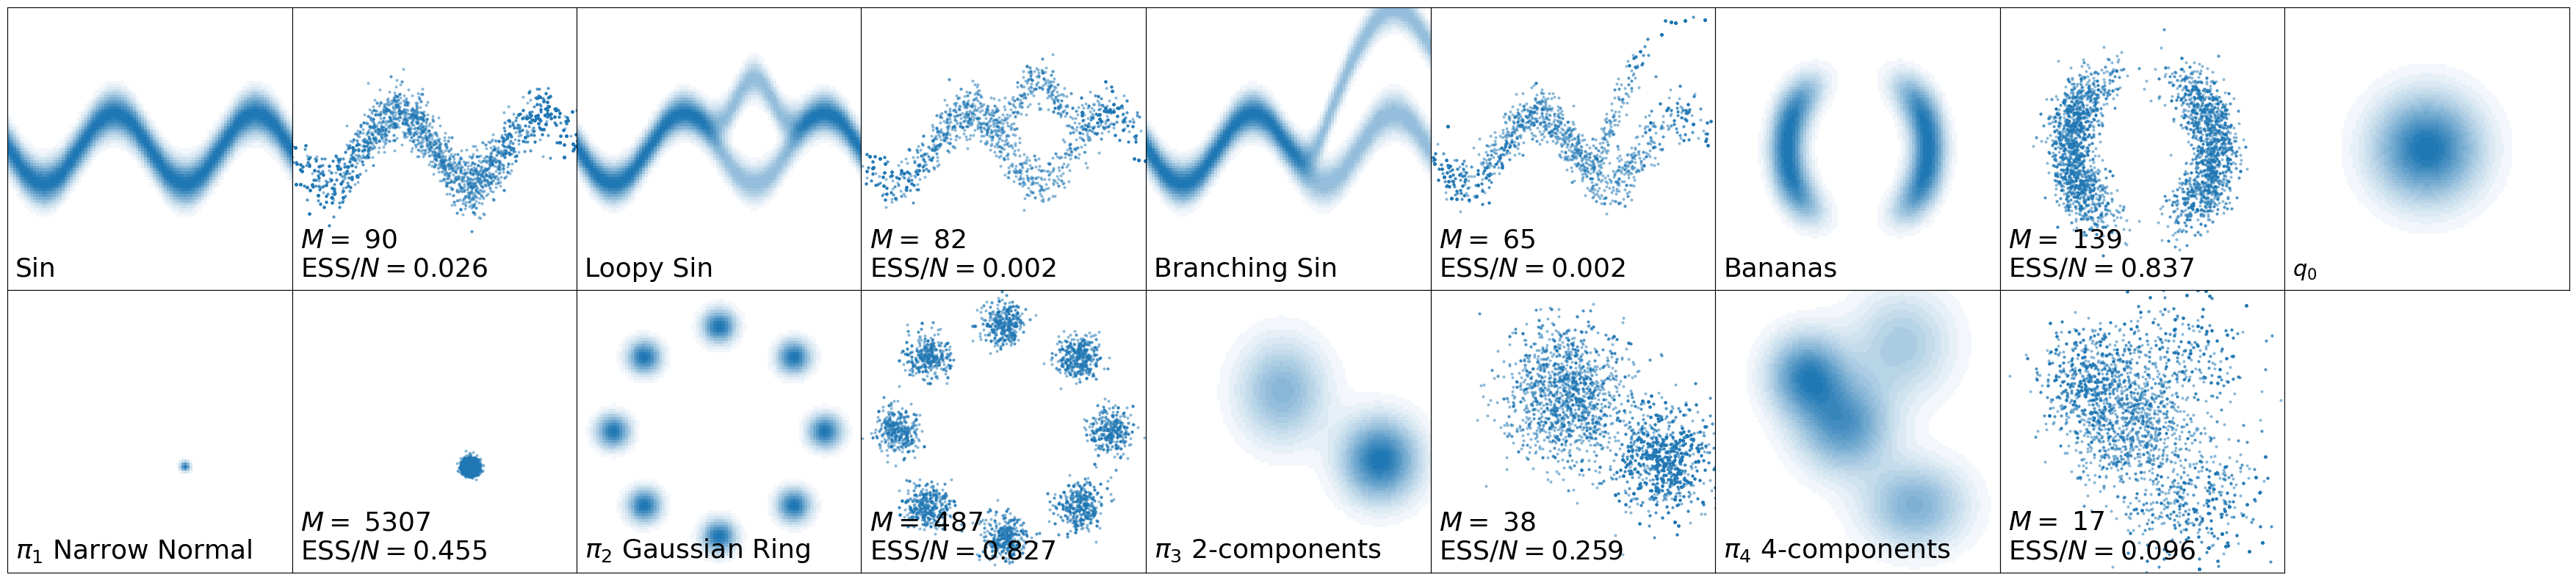

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, pickle

from utils.experiments import Default_ARGS as args
from utils.aux import get_ess, resample
from utils.targets import synthetic_targets
from utils.experiments import get_modified_experiment, get_dirs
from utils.plots import plot_energy_heatmap, plot_particles
from sampling.utils import get_sampler, estimate

args.sampler='CR'    
args.testname="tests/ffa772"

## Target distribution
args.target='U6'
args.latent_dim=2
args.dataset=None
args.context_dim=0

## Sampling parameters
args.seed = 1
args.M=32
args.n_samples=32
args.schedule='linear'
args.path='power'
args.annealing_alpha=0.
args.device=1
args.redo=True

## Transitions
args.transition='HMC'
args.transition_hidden_dim=4
args.transition_step_size=0.5
#args.transition_update='grad-std-tune'
args.transition_update = 'fixed'
args.transition_n_tune=1
args.hmc_partial_refresh = 10
args.hmc_alpha = 1.
args.hmc_n_leapfrogs = 1

args.min_step=0.000001
args.max_step=1./128
args.ratio=0.5
args.conditional=False
args.dt = 1./32
args.max_M = 8192
args.kde = False
args.tol=1e-3

args, experiment, label = get_modified_experiment(args, args.sampler, config={
    'transition_step_size':args.transition_step_size,
    'transition_update':args.transition_update,
    'transition_n_tune':args.transition_n_tune,
    'hmc_partial_refresh': args.hmc_partial_refresh,
    'hmc_alpha': args.hmc_alpha,
    'hmc_n_leapfrogs': args.hmc_n_leapfrogs,
})
plot_x = None
labels = ['Sin', 'Loopy Sin', 'Branching Sin', 'Bananas', 'Narrow Normal', 'Gaussian Ring', '2-components', '4-components', '8-components', '16-components']
targets = ['U2', 'U3', 'U4', 'U1', 'U6', 'U5', 'U10', 'U11']#, 'U12', 'U13']
fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(45, 10))
br = 4
i = 0
for label, target in zip(labels, targets):
    target_log_density = synthetic_targets[target]
    target_log_density.cuda()
    plot_energy_heatmap(ax[i // br, int(i % br)*2], target_log_density, x=None, cmap='blue')
    #plot_energy_heatmap(ax[i // br, int(i % br)*2 + 1], target_log_density, x=None, cmap='binary')
    ax[i // br, int(i % br)*2].set_xticks([])
    ax[i // br, int(i % br)*2].set_yticks([])
    #ax[i // 4, int(i % 4) * 2].set_title(f'{label}', fontsize=18)
    pi = {'U6':r'$\pi_1$','U5':r'$\pi_2$','U10':r'$\pi_3$',
                  'U11':r'$\pi_4$','U12':r'$\pi_5$','U13':r'$\pi_6$'}
    if target in pi.keys():
        label = pi[target] + ' ' + label
    ax[i // br, int(i % br)*2].annotate(label, xy=(8, 8), xycoords='axes points',
        size=26, ha='left', va='bottom')

    args.target = target
    sampler, dirs = get_sampler(args, experiment, target_log_density, make_dirs=True)
    sampler.eval()
    print(dirs[0])
    
    z, log_w, transition_logs = sampler.sample(args.n_samples, plot_x, update_step_size=True, log=True)
    zs = transition_logs['z'].reshape(args.n_samples, -1, target_log_density.data_dim, sampler.M + 1)
    log_ws = transition_logs['log_w'].reshape(args.n_samples, -1, sampler.M + 1)
    betas = torch.cat([torch.tensor([0.]).to(sampler.beta.device), sampler.beta], dim=0)
    log_accept_ratio = transition_logs['log_accept_ratio'].reshape(args.n_samples, -1)
    #weight_stats(log_ws[:,:,-1:], target_log_density, n_samples=args.n_samples, prefix='', just_log=True)
    
    sampler.tune_beta = False
    n_samples = 4096
    z, log_w, transition_logs = sampler.sample(n_samples, plot_x, update_step_size=False, log=True)
    zs = transition_logs['z'].reshape(n_samples, -1, target_log_density.data_dim, sampler.M + 1)
    log_ws = transition_logs['log_w'].reshape(n_samples, -1, sampler.M + 1)
    betas = torch.cat([torch.tensor([0.]).to(sampler.beta.device), sampler.beta], dim=0)
    log_accept_ratio = transition_logs['log_accept_ratio'].reshape(n_samples, -1)

    transition_logs['beta'] = torch.cat([torch.tensor([0.]).to(sampler.beta.device), sampler.beta], dim=0)
    with open(os.path.join(dirs[-1], 'all.pkl'), 'wb+') as f:
          pickle.dump({'eval_transitions':[transition_logs]}, f)
    estimate(transition_logs, target_log_density, n_samples=n_samples, prefix='', just_log=True)
    ess = get_ess(log_ws[:,:,-1]).item()
    print(log_ws[:5,0,-1])
    print('ESS = ', ess)
    plot_particles(ax[i // br, int(i % br)*2+1], resample(zs[:,0,:,-1], log_ws[:,0,-1]))
    label=r'$M = $ ' + f'{sampler.M}\n' + r'ESS$/N = $' +  f'{ess/n_samples:.3f}'
    ax[i // br, int(i % br)*2 + 1].set_xticks([])
    ax[i // br, int(i % br)*2 + 1].set_yticks([])
    ax[i // br, int(i % br)*2 + 1].annotate(label, xy=(8, 8), xycoords='axes points',
        size=26, ha='left', va='bottom')

    print('M = ', sampler.M)
    #print(sampler.beta[-10:])
    #print(transition_logs['kde_var'][-10:])
    
    i += 1

target_log_density = synthetic_targets['U0']
target_log_density.cuda()
plot_energy_heatmap(ax[0,2 * br], target_log_density, x=None, cmap='blue')
ax[1,2 * br].spines['bottom'].set_visible(False)
ax[1,2 * br].spines['right'].set_visible(False)
ax[1,2 * br].set_xticks([])
ax[1,2 * br].set_yticks([])
ax[0,2 * br].set_xticks([])
ax[0,2 * br].set_yticks([])
ax[0,2 * br].annotate(r'$q_0$', xy=(8, 8), xycoords='axes points',
        size=22, ha='left', va='bottom')
os.makedirs(f'{args.testname}/plots', exist_ok=True)
plt.subplots_adjust(wspace=0., hspace=.0)
plt.savefig(f'{args.testname}/plots/particles.pdf', format='pdf', transparent=True, bbox_inches='tight', pad_inches = 0)

